# Polynomial Fitting

Similarly to the linear fit and the transit model we can instead fit our data with a polynomial model. The difference from the linear fit tutorial is that in this case we'll generate a slightly different polynomial function  for each wavelength and see how well our model can recover the parameters.

In [1]:
from chromatic_fitting import *
from pymc3 import Normal, Uniform

plt.matplotlib.style.use('default')

Running chromatic_fitting v0.6.1!

This program is running on:
Python v3.9.12 (main, Apr  5 2022, 01:52:34) 
[Clang 12.0.0 ]
numpy v1.21.5
chromatic v0.4.3
pymc3 v3.11.4
pymc3_ext v0.1.1
exoplanet v0.5.3


First we'll create a Rainbow object from chromatic and then add a wavelength-dependent polynomial model:

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

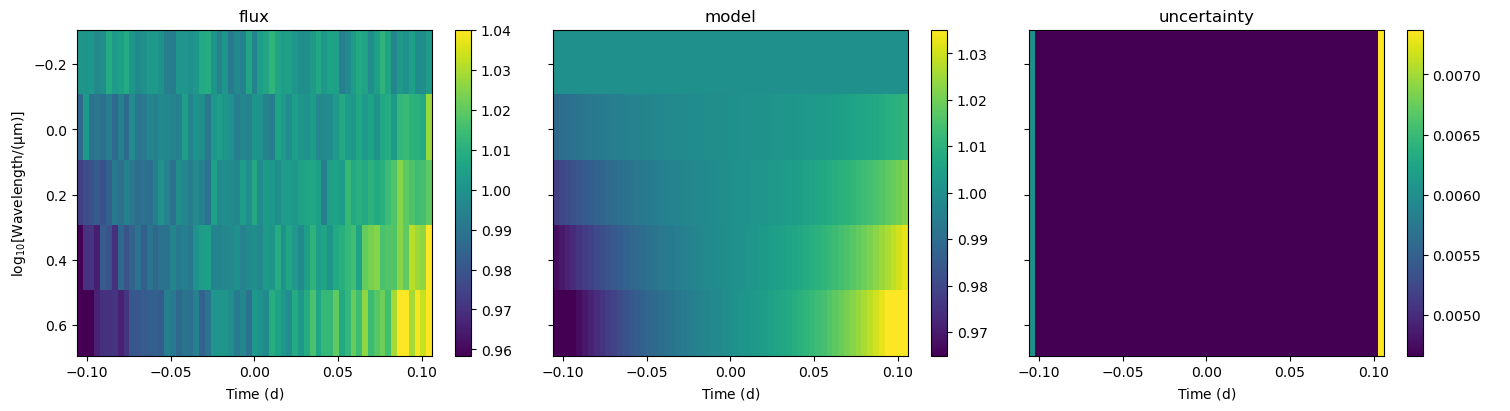

In [2]:
# create simulated rainbow
r = SimulatedRainbow(dt=1 * u.minute, R=50).inject_noise(signal_to_noise=20)

# bin:
nw = 5
rb = r.bin(nwavelengths=int(r.nwave/nw), dt=5 * u.minute)

# create wavelength-dep linear + constant model:
a = 0.0
b = 0.05
c = 0.0
d = 5.0
x = rb.time.to_value("day")

true_a, true_b, true_c, true_d, poly = [],[],[],[],[]

for i in range(rb.nwave):
    true_a.append(a + 1)
    true_b.append(b*i)
    true_c.append(c*i)
    true_d.append(d*i)
    poly.append((d*i*(x**3)) + (c*i*(x**2)) + (b*i*x))
rb.fluxlike['flux'] = rb.flux + np.array(poly)
rb.fluxlike['model'] = 1 + np.array(poly)

# plot our Rainbow to see how it looks
rb.imshow_quantities();

Let's plot our data in 2-D so we can see the polynomial shapes we've added:

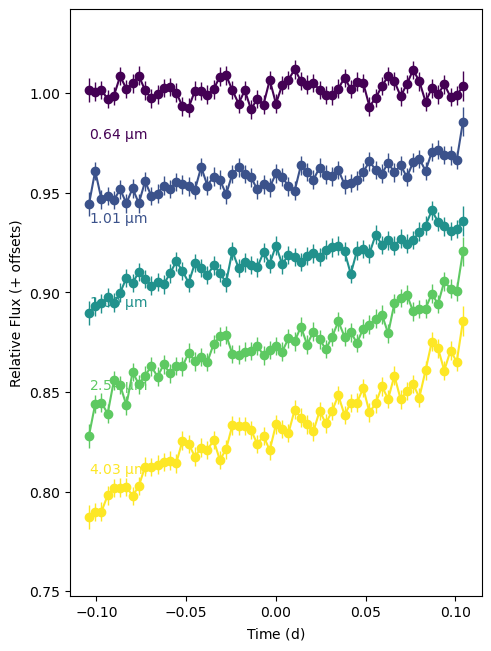

In [3]:
rb.plot_lightcurves();

## Create Polynomial Model

We set up the `PolynomialModel` similarly to the [linear model tutorial](https://catrionamurray.github.io/chromatic_fitting/tutorial_for_linear_fitting/), however, we need to provide the `degree` of the polynomial. By setting this argument we can fix some of our degrees to zero. For example if we have a linear model but we want a zero constant offset we could ignore the `p_0` parameter which would be fixed by default to 0. 

In [4]:
# set up polynomial model:
p = PolynomialModel(degree=3)

p.setup_parameters(
    p_0 = WavelikeFitted(Uniform,testval=0.01,upper=2,lower=-2),
    p_1 = WavelikeFitted(Uniform,testval=0.02,upper=1,lower=-1),
    p_2 = WavelikeFitted(Uniform,testval=0.03,upper=1,lower=-1),
    p_3 = WavelikeFitted(Uniform,testval=0.04,upper=25,lower=-5)
)

# print a summary of all params:
p.summarize_parameters()

polynomial_p_0 =
  <🧮 WavelikeFitted Uniform(testval=0.01, upper=2, lower=-2, name='polynomial_p_0') for each wavelength 🧮>

polynomial_p_1 =
  <🧮 WavelikeFitted Uniform(testval=0.02, upper=1, lower=-1, name='polynomial_p_1') for each wavelength 🧮>

polynomial_p_2 =
  <🧮 WavelikeFitted Uniform(testval=0.03, upper=1, lower=-1, name='polynomial_p_2') for each wavelength 🧮>

polynomial_p_3 =
  <🧮 WavelikeFitted Uniform(testval=0.04, upper=25, lower=-5, name='polynomial_p_3') for each wavelength 🧮>



In [5]:
p.parameters

{'polynomial_p_0': <🧮 WavelikeFitted Uniform(testval=0.01, upper=2, lower=-2, name='polynomial_p_0') for each wavelength 🧮>,
 'polynomial_p_1': <🧮 WavelikeFitted Uniform(testval=0.02, upper=1, lower=-1, name='polynomial_p_1') for each wavelength 🧮>,
 'polynomial_p_2': <🧮 WavelikeFitted Uniform(testval=0.03, upper=1, lower=-1, name='polynomial_p_2') for each wavelength 🧮>,
 'polynomial_p_3': <🧮 WavelikeFitted Uniform(testval=0.04, upper=25, lower=-5, name='polynomial_p_3') for each wavelength 🧮>}

In [6]:
# setup model the same way as for the transit model!:
p.attach_data(rb)

# If we don't want to fit everything simultaneously we can change the optimization method (the options 
# are "separate" or "white_light"). This has to be set BEFORE running .setup_lightcurves!
# p.choose_optimization_method("separate")

p.setup_lightcurves(store_models=True)

p.setup_likelihood()

In [7]:
p.parameters

{'polynomial_p_0': <🧮 WavelikeFitted Uniform(testval=0.01, upper=2, lower=-2, name='polynomial_p_0', shape=5) for each wavelength 🧮>,
 'polynomial_p_1': <🧮 WavelikeFitted Uniform(testval=0.02, upper=1, lower=-1, name='polynomial_p_1', shape=5) for each wavelength 🧮>,
 'polynomial_p_2': <🧮 WavelikeFitted Uniform(testval=0.03, upper=1, lower=-1, name='polynomial_p_2', shape=5) for each wavelength 🧮>,
 'polynomial_p_3': <🧮 WavelikeFitted Uniform(testval=0.04, upper=25, lower=-5, name='polynomial_p_3', shape=5) for each wavelength 🧮>}

Let's check our PyMC3 model and make sure that the parameters have been set up okay!

In [8]:
print(p._pymc3_model)

polynomial_p_0_interval__ ~ TransformedDistribution
polynomial_p_1_interval__ ~ TransformedDistribution
polynomial_p_2_interval__ ~ TransformedDistribution
polynomial_p_3_interval__ ~ TransformedDistribution
           polynomial_p_0 ~ Uniform
           polynomial_p_1 ~ Uniform
           polynomial_p_2 ~ Uniform
           polynomial_p_3 ~ Uniform
         polynomial_model ~ Deterministic
                     data ~ Normal


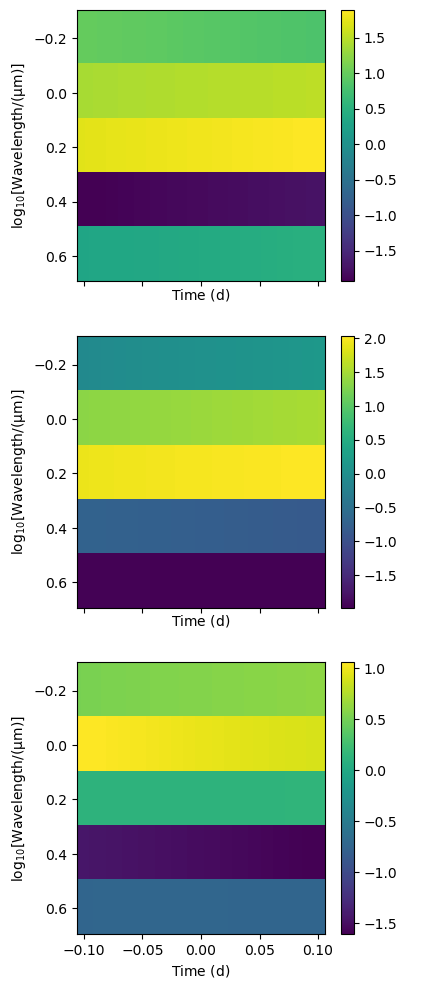

In [9]:
p.plot_priors()

Looks good, now onto sampling our model...

## Sampling our Model

Now we can try to fit our model! Here we will first perform an optimization step (to give our sampling a good first guess) and then the actual NUTS sampling with a number of tuning and draw steps and chains that we define. We can also choose how many cores to assign to this sampling! Bear in mind that we have a decent number of parameters to fit (simultaneously) and so we want to make sure we have enough steps in the MCMC!

In [30]:
# optimize for initial values!
opt = p.optimize(plot=False)

# put those initial values into the sampling and define the number of tuning and draw steps, 
# as well as the number of chains.
p.sample(start=opt, tune=2000, draws=4000, chains=4, cores=4, return_inferencedata=False)

optimizing logp for variables: [polynomial_p_3, polynomial_p_2, polynomial_p_1, polynomial_p_0]


message: Desired error not necessarily achieved due to precision loss.
logp: -6763748.124170256 -> 1192.0693575322832
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [polynomial_p_3, polynomial_p_2, polynomial_p_1, polynomial_p_0]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 8 seconds.


Now we can look at our results:

In [31]:
p.summarize(round_to=7, hdi_prob=0.68, fmt='wide')

                             mean        sd   hdi_16%   hdi_84%  mcse_mean  \
polynomial_p_0[0]        1.000686  0.000900  0.999770  1.001553   0.000007   
polynomial_p_0[1]        0.998857  0.000912  0.997928  0.999755   0.000007   
polynomial_p_0[2]        1.001652  0.000908  1.000715  1.002516   0.000007   
polynomial_p_0[3]        1.000244  0.000908  0.999374  1.001172   0.000007   
polynomial_p_0[4]        1.000241  0.000900  0.999372  1.001149   0.000007   
...                           ...       ...       ...       ...        ...   
polynomial_model[4, 56]  1.029692  0.001482  1.028201  1.031130   0.000011   
polynomial_model[4, 57]  1.031681  0.001663  1.029931  1.033211   0.000012   
polynomial_model[4, 58]  1.033771  0.001877  1.031784  1.035505   0.000014   
polynomial_model[4, 59]  1.035964  0.002123  1.033682  1.037890   0.000016   
polynomial_model[4, 60]  1.038266  0.002400  1.035831  1.040574   0.000019   

                          mcse_sd      ess_bulk      ess_tail  

r_hat parameters are close to 1, which is a good sign that our chains have converged!

In [32]:
p.get_results(uncertainty=['hdi_16%','hdi_84%'])

,polynomial_p_0,polynomial_p_0_hdi_16%,polynomial_p_0_hdi_84%,polynomial_p_1,polynomial_p_1_hdi_16%,polynomial_p_1_hdi_84%,polynomial_p_2,polynomial_p_2_hdi_16%,polynomial_p_2_hdi_84%,polynomial_p_3,polynomial_p_3_hdi_16%,polynomial_p_3_hdi_84%,wavelength
w0,1.000686,0.99977,1.001553,-0.049109,-0.073089,-0.023616,0.082714,-0.103065,0.267713,5.619747,2.167106,9.099583,0.639572482934883 micron
w1,0.998857,0.997928,0.999755,0.066893,0.046578,0.093769,0.236763,0.055432,0.424641,1.383201,-2.143325,4.431745,1.013209338074884 micron
w2,1.001652,1.000715,1.002516,0.089065,0.063384,0.11304,-0.286388,-0.464206,-0.097275,11.050339,7.733019,14.679788,1.604998553797903 micron
w3,1.000244,0.999374,1.001172,0.144878,0.12193,0.171155,0.141947,-0.038845,0.330958,15.070328,11.630073,18.519216,2.542436455025025 micron
w4,1.000241,0.999372,1.001149,0.221933,0.195437,0.243996,-0.265339,-0.44215,-0.071157,15.736282,12.189522,19.041086,4.027407446906737 micron


In [33]:
model = p.get_model()
model.keys()

dict_keys(['w0', 'w1', 'w2', 'w3', 'w4'])

## Plot Results

Remember that handy `plot_lightcurves()` function from earlier? Once we have generated a model it *should* now overplot those models on top of the data.

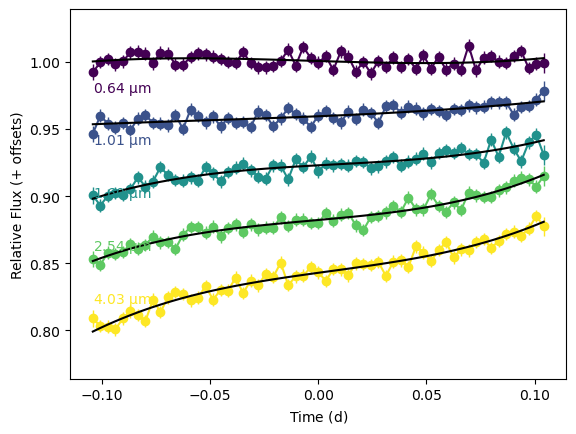

In [34]:
p.plot_lightcurves()

We can also use the `chromatic` functions wrapped in `chromatic_fitting` that can let us look at the residuals:

No model attached to data. Running `add_model_to_rainbow` now. You can access this data later using [self].data_with_model


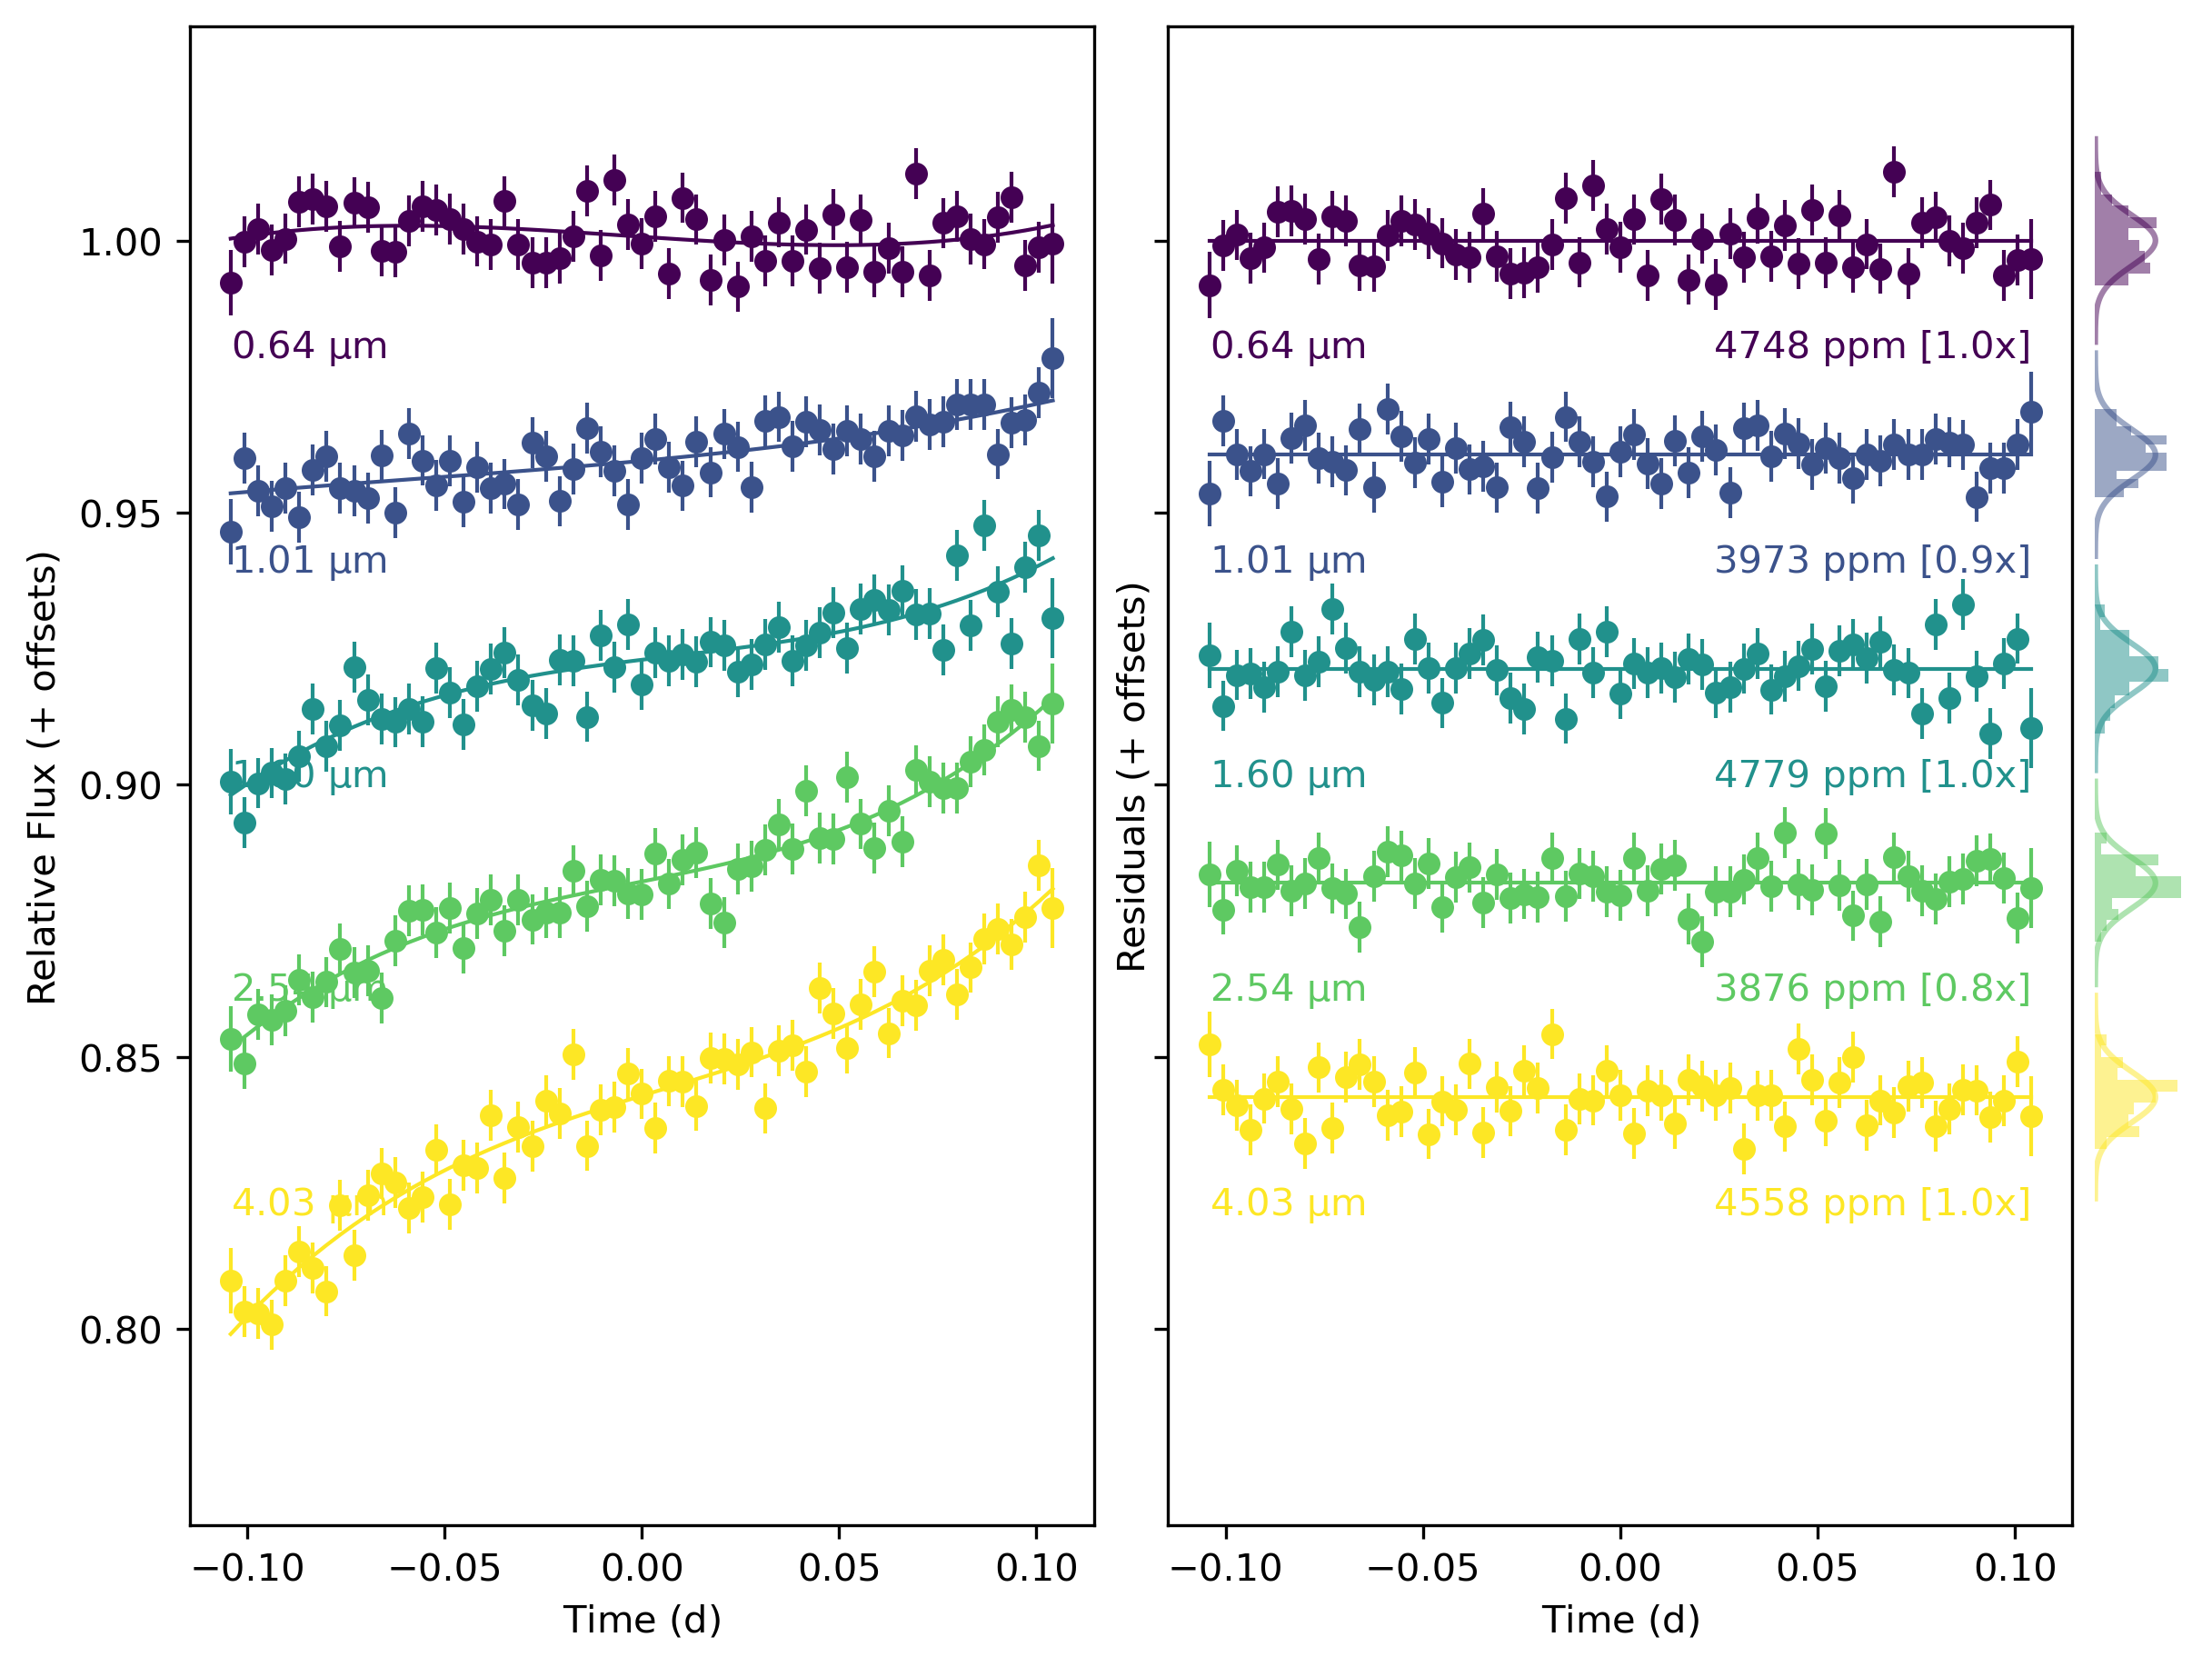

In [35]:
p.plot_with_model_and_residuals()

🌈🤖 'planet_model' doesn't exist and will be skipped.



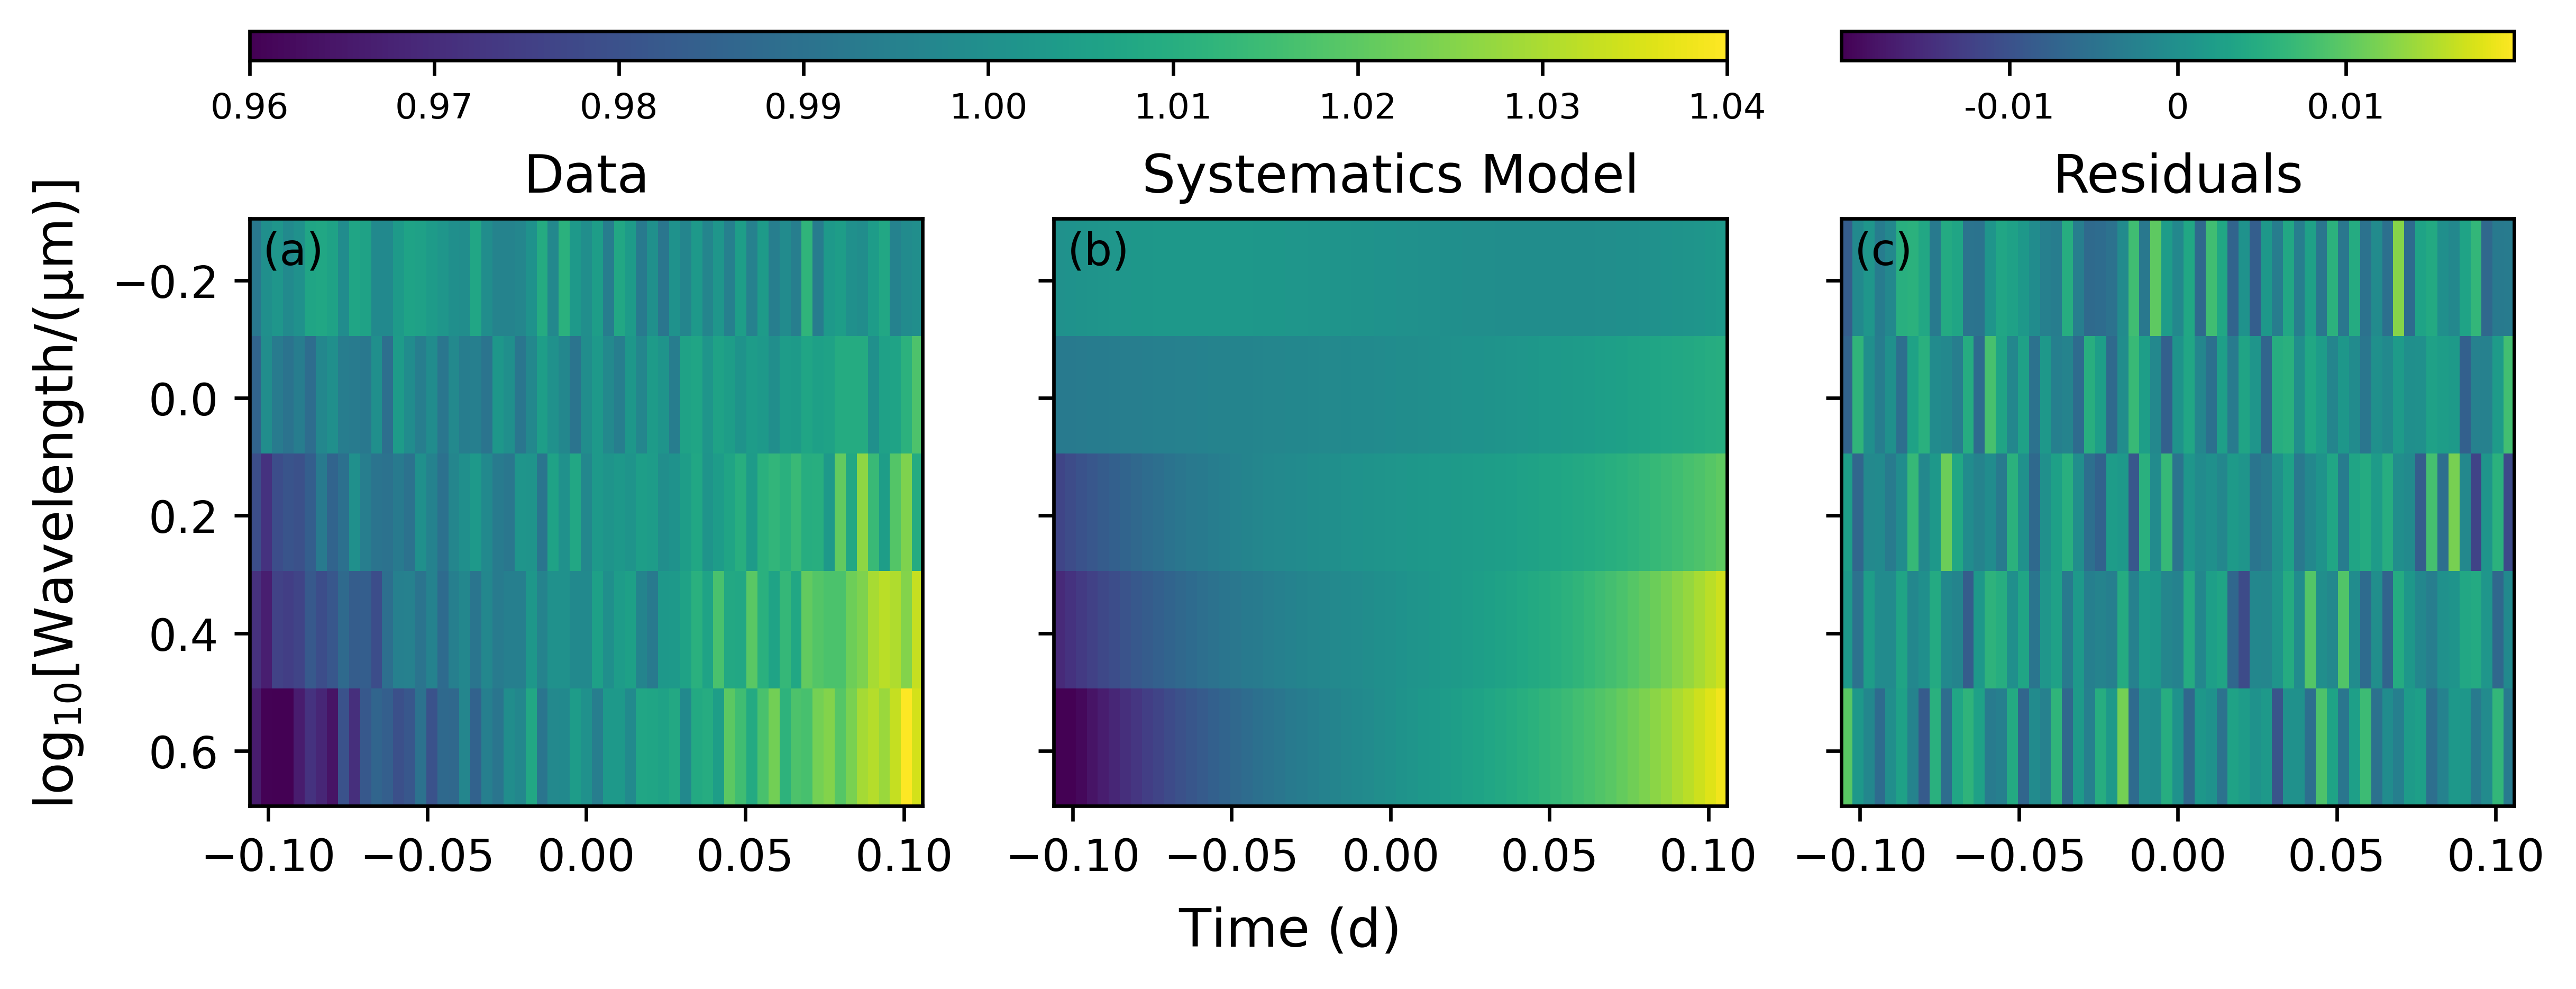

In [36]:
p.imshow_with_models(vlimits_data=[0.96, 1.04])

## Compare Results to the True Values

We can also compare our fitted results to the true values we put in:

In [37]:
results = p.get_results(uncertainty=['sd','sd'])
results

,polynomial_p_0,polynomial_p_0_sd,polynomial_p_1,polynomial_p_1_sd,polynomial_p_2,polynomial_p_2_sd,polynomial_p_3,polynomial_p_3_sd,wavelength
w0,1.000686,0.0009,-0.049109,0.024925,0.082714,0.187037,5.619747,3.484665,0.639572482934883 micron
w1,0.998857,0.000912,0.066893,0.023216,0.236763,0.185964,1.383201,3.193942,1.013209338074884 micron
w2,1.001652,0.000908,0.089065,0.024909,-0.286388,0.184213,11.050339,3.487702,1.604998553797903 micron
w3,1.000244,0.000908,0.144878,0.024975,0.141947,0.186801,15.070328,3.514289,2.542436455025025 micron
w4,1.000241,0.0009,0.221933,0.02432,-0.265339,0.18652,15.736282,3.397105,4.027407446906737 micron


In [38]:
print("\t\t\tTrue, \tFitted")
for w in range(p.data.nwave):
    for i, coeff in zip(range(p.degree+1),[true_a, true_b, true_c, true_d]):
        print(f"wavelength {w}, p_{i}:\t {round(coeff[w],2)}, \t",results.loc[f'w{w}'][f"{p.name}_p_{i}"],"+/-",results.loc[f'w{w}'][f"{p.name}_p_{i}_sd"])

			True, 	Fitted
wavelength 0, p_0:	 1.0, 	 1.0006861 +/- 0.0008999
wavelength 0, p_1:	 0.0, 	 -0.0491093 +/- 0.0249255
wavelength 0, p_2:	 0.0, 	 0.0827142 +/- 0.1870369
wavelength 0, p_3:	 0.0, 	 5.6197472 +/- 3.4846653
wavelength 1, p_0:	 1.0, 	 0.9988569 +/- 0.0009123
wavelength 1, p_1:	 0.05, 	 0.0668931 +/- 0.0232163
wavelength 1, p_2:	 0.0, 	 0.2367628 +/- 0.1859638
wavelength 1, p_3:	 5.0, 	 1.3832012 +/- 3.193942
wavelength 2, p_0:	 1.0, 	 1.0016518 +/- 0.0009079
wavelength 2, p_1:	 0.1, 	 0.0890647 +/- 0.0249093
wavelength 2, p_2:	 0.0, 	 -0.2863881 +/- 0.1842134
wavelength 2, p_3:	 10.0, 	 11.0503395 +/- 3.4877016
wavelength 3, p_0:	 1.0, 	 1.0002443 +/- 0.0009077
wavelength 3, p_1:	 0.15, 	 0.1448778 +/- 0.0249748
wavelength 3, p_2:	 0.0, 	 0.1419473 +/- 0.1868009
wavelength 3, p_3:	 15.0, 	 15.0703278 +/- 3.5142888
wavelength 4, p_0:	 1.0, 	 1.000241 +/- 0.0008998
wavelength 4, p_1:	 0.2, 	 0.2219329 +/- 0.0243203
wavelength 4, p_2:	 0.0, 	 -0.2653392 +/- 0.1865198
wavelen

Let's plot the data, the true regression line and our fit and see how they compare (If we used `store_model=True` at the `.setup_lightcurves()` stage then we could easily generate a 1-sigma region for the model using the errors stored in the summary table!):

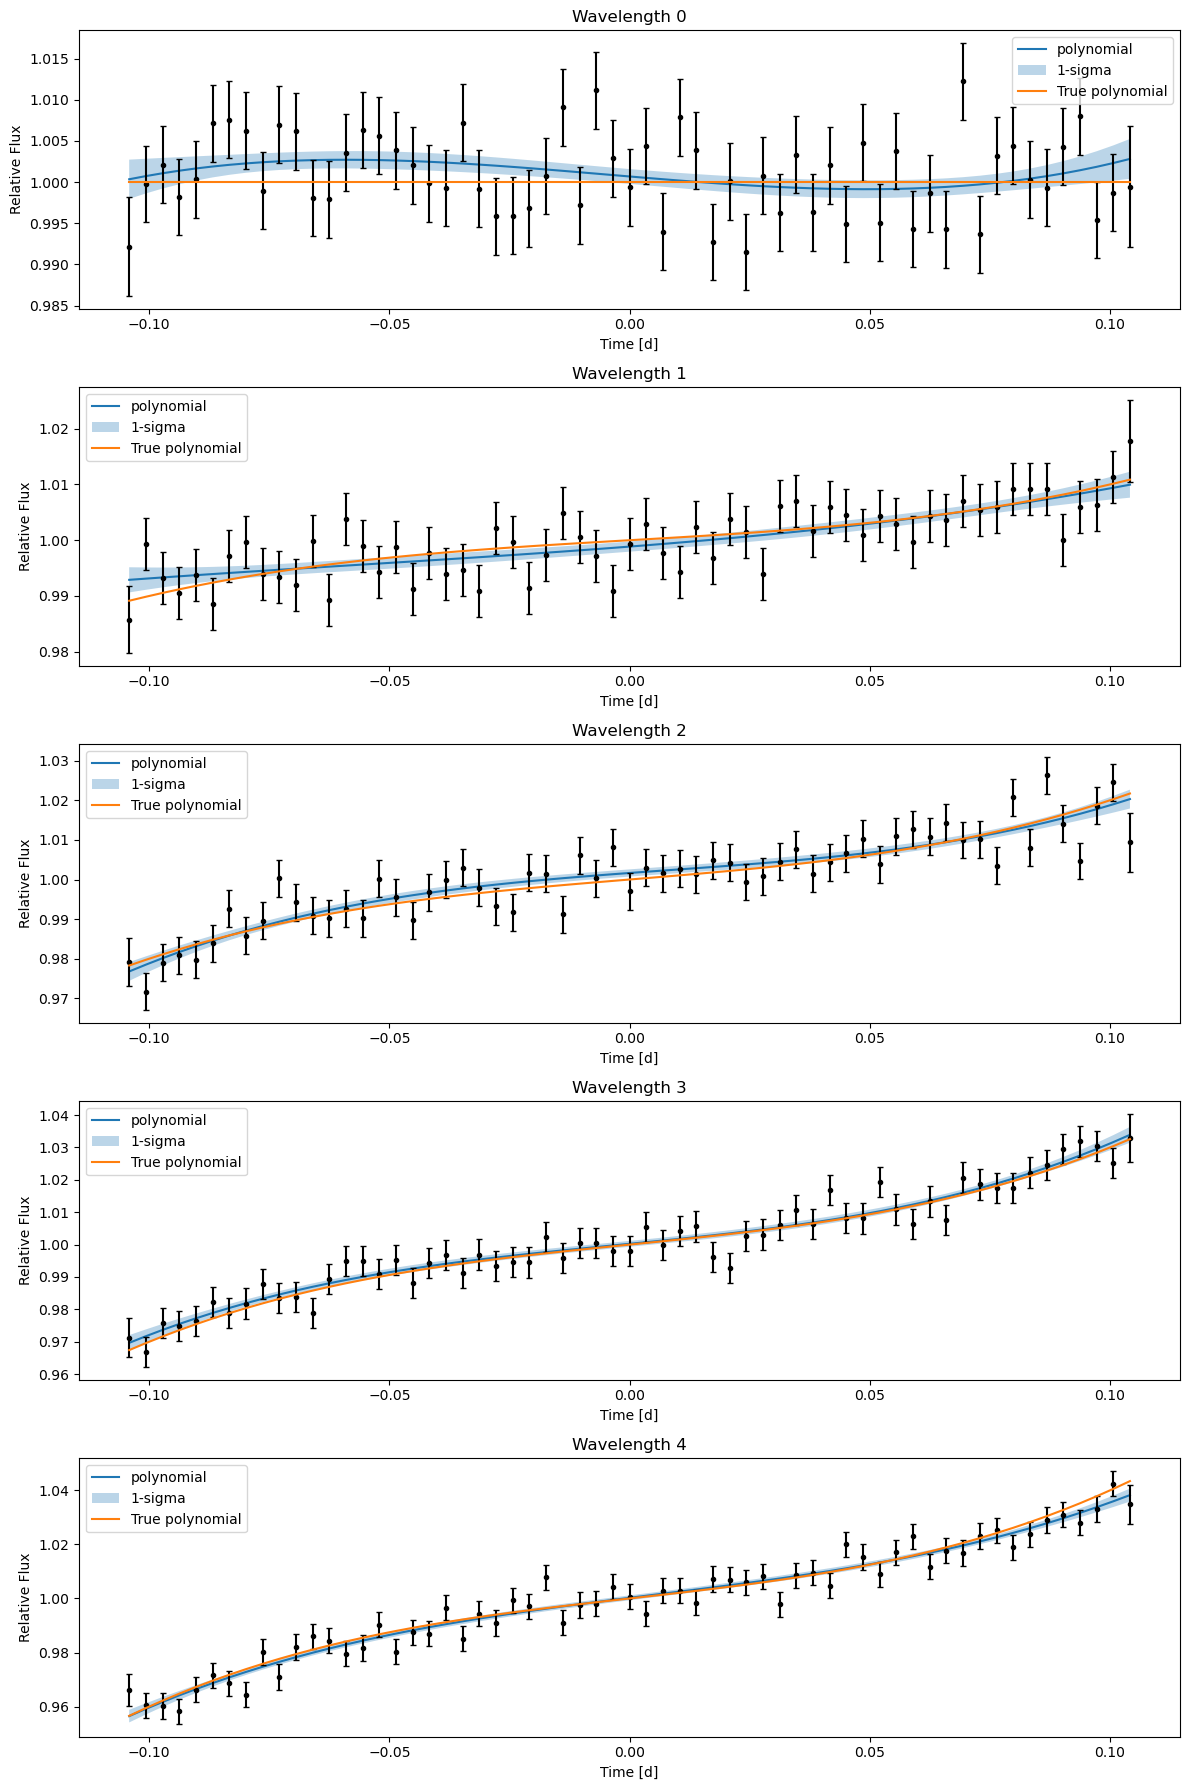

In [39]:
fig, ax = plt.subplots(p.data.nwave, figsize=(12,18))
p.plot_model(ax=ax)
plt.tight_layout();

# get 1-sigma region (only if store_models=True!!):
onesigma={}
for w in range(p.data.nwave):
    if f"w{w}" not in onesigma.keys():
        onesigma[f"w{w}"] = []
    for t in range(p.data.ntime):
        if p.optimization == "separate":
            onesigma[f"w{w}"].append(p.summary[w]["sd"][f"{p.name}_model[0, {t}]"])
        else:
            onesigma[f"w{w}"].append(p.summary["sd"][f"{p.name}_model[{w}, {t}]"])
        
        
for i in range(len(poly)):
    ax[i].fill_between(p.data.time.to_value("d"), np.array(model[f"w{i}"])-onesigma[f"w{i}"], np.array(model[f"w{i}"])+onesigma[f"w{i}"], label='1-sigma', alpha=0.3)
    ax[i].plot(p.data.time, p.data.model[i], label="True polynomial")
    ax[i].legend()

This is a good example to see where the model does a good job of fitting, and where, when the noise is larger than the signal, it can overfit (wavelength 0).

/Users/camu5866/opt/anaconda3/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


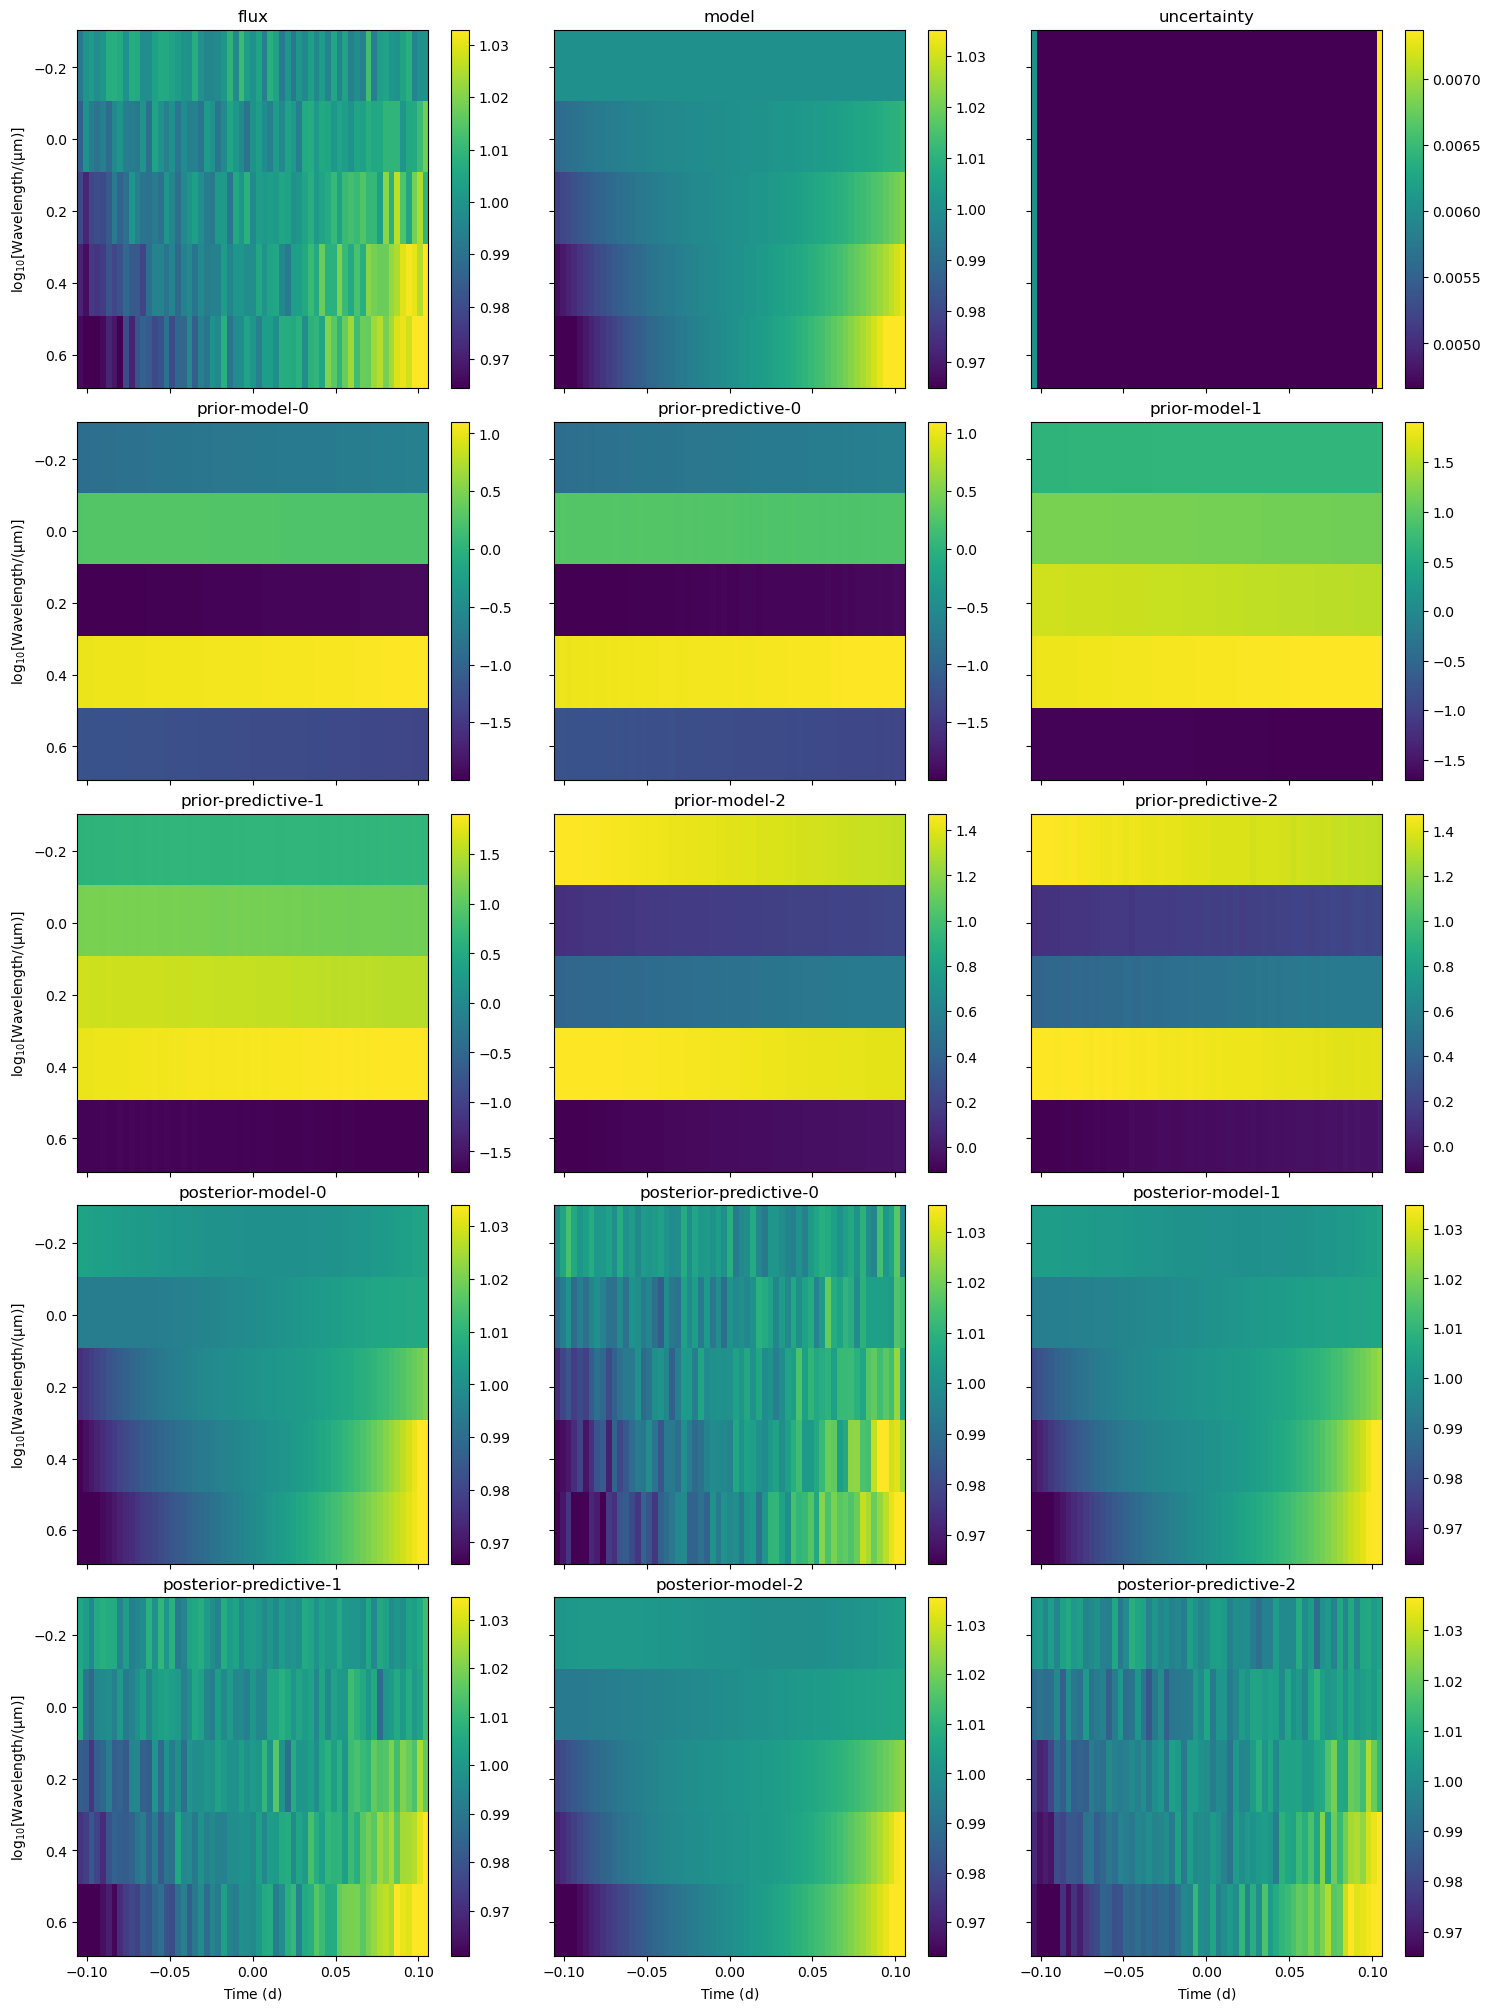

In [40]:
p.plot_posteriors()

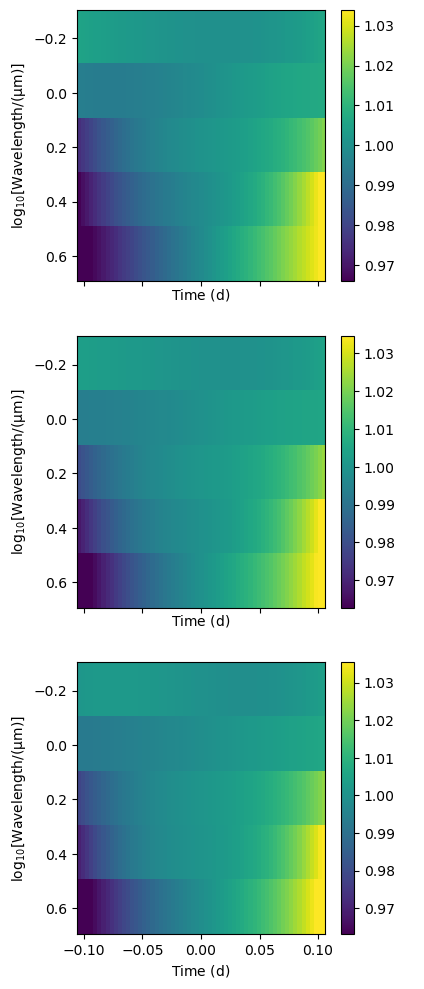

In [61]:
f, ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(4,12))
p.data.imshow(ax=ax[0],quantity="posterior-model-0");
p.data.imshow(ax=ax[1],quantity="posterior-model-1");
p.data.imshow(ax=ax[2],quantity="posterior-model-2");